## IAPR24: Coin Counter Project 
### Group 23

Here is how our project is structured
```code
├── main.ipynb
├── utils.py
└── data-coin-counter
        ├── ref
        │    ├── ref_chf.JPG
        │    └── ref_eur.JPG  
        ├── test
        └── train
            ├── 1. neutral_bg
            ├── 2. noisy_bg
            ├── 3. hand
            ├── 4. neutral_bg_outliers
            ├── 5. noisy_bg_outliers
            ├── 6. hand_outliers 
            └── train_labels.csv          
      


In [1]:
import os
import re
import copy 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader,  Dataset

from torchvision.models import resnet50,ResNet50_Weights
import torch.nn.functional as F

from sklearn.metrics import f1_score

from collections import defaultdict
from typing import List, Tuple, Dict

from PIL import Image, ImageFilter
from skimage import filters
from typing import Callable
from skimage.color import rgb2yiq, rgb2hsv
from sklearn.model_selection import train_test_split

In [39]:
from utils import find_threshold, preprocessing, contours,cropped, radius


In [12]:
current_path = os.getcwd()
print(current_path)
# add the pathdata
data_path_CHF = os.path.join(current_path, "data-coin-counter/ref/ref_chf.JPG")
data_path_EU = os.path.join(current_path, "data-coin-counter/ref/ref_eur.JPG")


#data_path = "/data/data_project/ref/ref_chf.JPG"
image_ref_CHF = Image.open(data_path_CHF)
image_ref_EU = Image.open(data_path_EU)

c:\Users\emy8\OneDrive\Documents\EPFL\Master\MA4\IAPR\IAPR_Lab


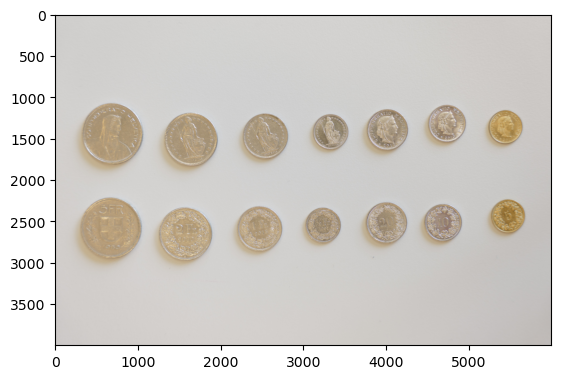

In [4]:
plt.imshow(image_ref_CHF)

In [ ]:
plt.imshow(image_ref_EU)

In [ ]:
find_threshold(image_ref_CHF)

## CHF coins

In [ ]:
image_postprocessing_CHF=preprocessing(image_ref_CHF)
plt.imshow(image_postprocessing_CHF, cmap="gray")

In [ ]:
contours_CHF=contours(image_postprocessing_CHF)
print(len(contours_CHF))

In [ ]:
for contour in contours_CHF:
    plt.plot(contour[:,0],contour[:,1], color = "red")
plt.imshow(image_ref_CHF)
plt.show()

In [ ]:
cropped_images_CHF,centroids_CHF=cropped(image_ref_CHF,contours_CHF)

In [ ]:
plt.imshow(cropped_images_CHF[13])

In [ ]:
print(centroids_CHF[13])

In [ ]:
labels=[1,6,5,7,2,3,4,8,14,12,13,10,9,11]
rads=radius(contours_CHF)

In [ ]:
for patches, centroid, r, label in zip(cropped_images_CHF,centroids_CHF,rads, labels):
    Image.fromarray(patches).save(f'data-coin-counter/ref/ref_chf_{centroid[0]}_{centroid[1]}_{r}_{label}.JPG', 'jpeg')
    #plt.imsave()

## € coins

In [ ]:
image_postprocessing_EU=preprocessing(image_ref_EU)
plt.imshow(image_postprocessing_EU, cmap="gray")

In [ ]:
contours_EU=contours(image_postprocessing_EU)
print(len(contours_EU))

In [ ]:
for contour in contours_EU:
    plt.plot(contour[:,0],contour[:,1], color = "red")
plt.imshow(image_ref_EU)
plt.show()

In [ ]:
cropped_images_EU,centroid_EU=cropped(image_ref_EU,contours_EU)


In [ ]:
plt.imshow(cropped_images_EU[7])

In [ ]:
labels_EU=[3,1,4,2,5,6,7,8]
rads_EU=radius(contours_EU)

In [ ]:
for cro, cent, radi, label in zip(cropped_images_EU,centroid_EU,rads_EU, labels):
    Image.fromarray(cro).save(f'data-coin-counter/ref/ref_eu_{cent[0]}_{cent[1]}_{radi}_{label}.JPG', 'jpeg')
    

## Generate image patches 

In [5]:
from utils import generate_patches

In [5]:
base = "data-coin-counter/train"

#where we put the patches
new_folder_name = "Patches"

new_folder_path = os.path.join(base, new_folder_name)

# Check if the folder already exists, if not, create it
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)
    print(f"Folder '{new_folder_name}' created successfully at '{new_folder_path}'")
else:
    print(f"Folder '{new_folder_name}' already exists at '{new_folder_path}'")


Folder 'Patches' already exists at 'data-coin-counter/train\Patches'


### Neutral Background

path_in data-coin-counter/train\1. neutral_bg\L1010277.JPG
filename L1010277


c:\Users\emy8\OneDrive\Documents\EPFL\Master\MA4\IAPR\IAPR_Lab\utils.py:45: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  new = remove_small_holes(new, 500)


path_in data-coin-counter/train\1. neutral_bg\L1010279.JPG
filename L1010279
path_in data-coin-counter/train\1. neutral_bg\L1010281.JPG
filename L1010281
path_in data-coin-counter/train\1. neutral_bg\L1010283.JPG
filename L1010283
path_in data-coin-counter/train\1. neutral_bg\L1010287.JPG
filename L1010287
path_in data-coin-counter/train\1. neutral_bg\L1010288.JPG
filename L1010288
path_in data-coin-counter/train\1. neutral_bg\L1010294.JPG
filename L1010294
path_in data-coin-counter/train\1. neutral_bg\L1010297.JPG
filename L1010297
path_in data-coin-counter/train\1. neutral_bg\L1010298.JPG
filename L1010298
path_in data-coin-counter/train\1. neutral_bg\L1010300.JPG
filename L1010300
path_in data-coin-counter/train\1. neutral_bg\L1010308.JPG
filename L1010308
path_in data-coin-counter/train\1. neutral_bg\L1010310.JPG
filename L1010310
path_in data-coin-counter/train\1. neutral_bg\L1010311.JPG
filename L1010311
path_in data-coin-counter/train\1. neutral_bg\L1010318.JPG
filename L1010318

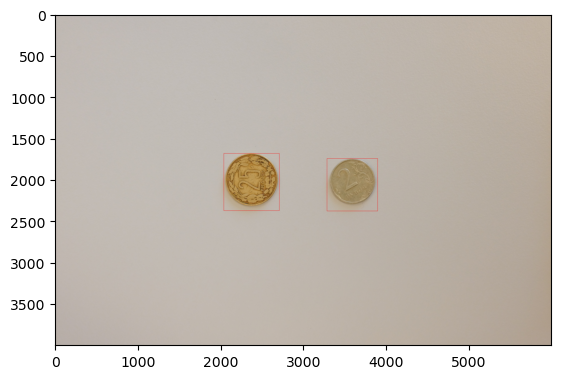

In [11]:
subfolders=["1. neutral_bg","4. neutral_bg_outliers"]
#subfolders = ["1. neutral_bg", "2. noisy_bg", "3. hand", "4. neutral_bg_outliers", "5. noisy_bg_outliers", "6. hand_outliers"]

for sub in subfolders:
    path=os.path.join(base,sub)
    files= os.listdir(path)
    for filename in files:
        print('path_in',os.path.join(path,filename))
        print('filename',filename.split('.',2)[0])
        generate_patches(os.path.join(path,filename),filename.split('.',2)[0],sub, os.path.join(base,new_folder_name))

    

### Hand background

In [7]:
from utils import compute_patches_hand

In [10]:
base = "data-coin-counter/train"
subfolders = ["3. hand",  "6. hand_outliers"]
for sub in subfolders:
    path=os.path.join(base,sub)
    files= os.listdir(path)
    for filename in files:
        print('path_in',os.path.join(path,filename))
        print('filename',filename.split('.',2)[0])
        compute_patches_hand(path_in=os.path.join(path,filename), save_dir=os.path.join(base,"Patches"),
                     name_image=filename.split('.',2)[0], subfolder=sub)

path_in data-coin-counter/train\3. hand\L1010373.JPG
filename L1010373
path_in data-coin-counter/train\3. hand\L1010375.JPG
filename L1010375
path_in data-coin-counter/train\3. hand\L1010377.JPG
filename L1010377
path_in data-coin-counter/train\3. hand\L1010378.JPG
filename L1010378
path_in data-coin-counter/train\3. hand\L1010382.JPG
filename L1010382
path_in data-coin-counter/train\3. hand\L1010383.JPG
filename L1010383
path_in data-coin-counter/train\3. hand\L1010388.JPG
filename L1010388
path_in data-coin-counter/train\3. hand\L1010390.JPG
filename L1010390
path_in data-coin-counter/train\3. hand\L1010391.JPG
filename L1010391
path_in data-coin-counter/train\3. hand\L1010395.JPG
filename L1010395
path_in data-coin-counter/train\6. hand_outliers\L1010506.JPG
filename L1010506
path_in data-coin-counter/train\6. hand_outliers\L1010510.JPG
filename L1010510
path_in data-coin-counter/train\6. hand_outliers\L1010515.JPG
filename L1010515
path_in data-coin-counter/train\6. hand_outliers\L

### Noisy background

In [6]:
from utils import compute_patches_noisy

path_in data-coin-counter/train\2. noisy_bg\L1010325.JPG
filename L1010325
path_in data-coin-counter/train\2. noisy_bg\L1010328.JPG
filename L1010328
path_in data-coin-counter/train\2. noisy_bg\L1010331.JPG
filename L1010331
path_in data-coin-counter/train\2. noisy_bg\L1010335.JPG
filename L1010335
path_in data-coin-counter/train\2. noisy_bg\L1010341.JPG
filename L1010341
path_in data-coin-counter/train\2. noisy_bg\L1010345.JPG
filename L1010345
path_in data-coin-counter/train\2. noisy_bg\L1010349.JPG
filename L1010349
path_in data-coin-counter/train\2. noisy_bg\L1010352.JPG
filename L1010352
path_in data-coin-counter/train\2. noisy_bg\L1010353.JPG
filename L1010353
path_in data-coin-counter/train\2. noisy_bg\L1010356.JPG
filename L1010356
path_in data-coin-counter/train\2. noisy_bg\L1010361.JPG
filename L1010361
path_in data-coin-counter/train\2. noisy_bg\L1010365.JPG
filename L1010365
path_in data-coin-counter/train\2. noisy_bg\L1010367.JPG
filename L1010367
path_in data-coin-counter

ValueError: cannot write empty image as JPEG

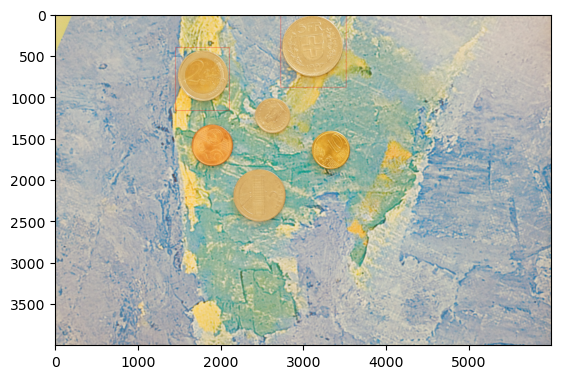

In [7]:
base = "data-coin-counter/train"
subfolders = ["2. noisy_bg",  "5. noisy_bg_outliers"]
for sub in subfolders:
    path=os.path.join(base,sub)
    files= os.listdir(path)
    for filename in files:
        print('path_in',os.path.join(path,filename))
        print('filename',filename.split('.',2)[0])
        compute_patches_noisy(path_in=os.path.join(path,filename), save_dir=os.path.join(base,"Patches"),
                     name_image=filename.split('.',2)[0], subfolder=sub)

## Check preprocessing

In [ ]:
#check preprocessing
sub = "1. neutral_bg"
base = "data-coin-counter/train"
path=os.path.join(base,sub)
files= os.listdir(path)

for filename in files:
    img=Image.open(os.path.join(path,filename))
    image_postprocessin=preprocessing(img)

    co=contours(image_postprocessin)
    print("filename: ", filename)

    for c in co:
        plt.plot(c[:,0],c[:,1], color = "red")
    plt.imshow(img)
    plt.show()

In [ ]:
sub = "4. neutral_bg_outliers"
base = "data-coin-counter/train"
path=os.path.join(base,sub)
files= os.listdir(path)

for filename in files:
    if (filename!= ".ipynb_checkpoints"):
        img=Image.open(os.path.join(path,filename))
        image_postprocessing=preprocessing(img)
        conto=contours(image_postprocessing)
        print("filename: ", filename)
        for cont in conto:
            plt.plot(cont[:,0],cont[:,1], color = "red")
        plt.imshow(img)
        plt.show()


In [ ]:
from utils import noisy_bg_crop

In [ ]:
subfolders= ["2. noisy_bg",  "5. noisy_bg_outliers"]
base = "data-coin-counter/train"
for sub in subfolders:
    path = os.path.join(base, sub)
    files = os.listdir(path)
    for filename in files:
        print("filename", filename)
        cropped_images, centroids,r=noisy_bg_crop(Image.open(os.path.join(path, filename)))
        plt.show()

In [ ]:
from utils import check_hand

In [ ]:
subfolders= ["3. hand",  "6. hand_outliers"]
base = "data-coin-counter/train"
for sub in subfolders:
    path = os.path.join(base, sub)
    files = os.listdir(path)
    for filename in files:
        check_hand(os.path.join(path, filename), filename)

## Features extractions 

#### include QIY also?

In [13]:
from utils import extract_rgb_channels, extract_hsv_channels

In [41]:
base = "data-coin-counter/train"
# create the dataset of features
columns_f = ["Image_label", "coin_label","Radius","Red_mean", "Green_mean", "Blue_mean","Red_std", "Green_std", "Blue_std", "Hue_mean", "Saturation_mean","Value_mean", "Hue_std", "Saturation_std","Value_std"]
features_dataset = pd.DataFrame(columns=columns_f)

#where we extract the patches
new_folder_name = "Patches_annoted"

path = os.path.join(base, new_folder_name)
#get the patches
files= os.listdir(path)

add 
calculate_texture(img):

In [42]:
for filename in files:
    path_in = os.path.join(path,filename)
    if '.ipynb_checkpoints' in path_in:
        continue  # Skip '.ipynb_checkpoints' 
        
    img = Image.open(path_in)

    Image_name = filename.split('-')[1]

    # retrieve the radius from the name
    radius_part= filename.split('-')[-1]
    rad = float(radius_part.split('.')[0] + '.' + radius_part.split('.')[1])

    label = filename.split('-')[0]

    data_r, data_g, data_b = extract_rgb_channels(np.array(img))
    data_h, data_s, data_v = extract_hsv_channels(np.array(img))

    mean_r = np.mean(data_r)
    mean_g = np.mean(data_g)
    mean_b = np.mean(data_b)

    std_r = np.std(data_r)
    std_g = np.std(data_g)
    std_b = np.std(data_b)

    mean_h = np.mean(data_h)
    mean_s = np.mean(data_s)
    mean_v = np.mean(data_v)

    std_h = np.std(data_h)
    std_s = np.std(data_s)
    std_v = np.std(data_v)

    array = [Image_name, label, rad, mean_r, mean_g, mean_b, std_r, std_g, std_b, mean_h, mean_s, mean_v, std_h, std_s, std_v]
    new_row = pd.DataFrame([array], columns=columns_f)
    if features_dataset.empty:
        features_dataset = new_row
    else:
        features_dataset = pd.concat([features_dataset, new_row], ignore_index=True)

In [43]:
features_dataset

,Image_label,coin_label,Radius,Red_mean,Green_mean,Blue_mean,Red_std,Green_std,Blue_std,Hue_mean,Saturation_mean,Value_mean,Hue_std,Saturation_std,Value_std
0,L1010434,14,271.264191,183.451127,157.836846,141.287019,14.938523,34.859146,46.093158,0.080029,0.238215,0.719419,0.050733,0.230187,0.058581
1,L1010318,7,193.423218,199.904637,182.402318,154.352295,14.867651,25.178017,49.587882,0.096039,0.236768,0.783940,0.018426,0.219694,0.058305
2,L1010308,13,269.947784,198.834223,167.666947,148.647091,10.709912,34.166944,49.182240,0.079305,0.253785,0.779744,0.064846,0.241885,0.042003
3,L1010377,14,210.834346,207.508076,164.209358,139.823841,25.622538,36.132210,35.579385,0.276752,0.339442,0.813766,0.375022,0.139014,0.100487
4,L1010323,15,224.280777,185.014371,161.841707,147.724383,16.989211,40.889058,52.035420,0.079892,0.218094,0.725554,0.054147,0.242423,0.066622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,L1010395,4,252.227127,188.783534,137.637171,116.691971,17.377172,28.589744,30.602889,0.154254,0.394829,0.740328,0.285745,0.121732,0.068147
200,L1010287,13,277.475433,184.897743,162.012710,141.195744,19.046644,40.935378,59.358803,0.092241,0.260777,0.725109,0.078578,0.262874,0.074680
201,L1010323,11,298.311157,185.076360,167.792497,137.268133,16.449365,29.054627,54.877951,0.109024,0.275153,0.726074,0.064829,0.258049,0.064523
202,L1010424,6,256.850739,177.705319,168.657396,155.227138,24.206129,27.545008,35.425979,0.103784,0.137246,0.696932,0.077262,0.108447,0.094961


In [44]:
# Not needed as patches are already extracted

set = np.unique(features_dataset['Image_label'])[1]
#extract the features of the image with the label set
raw_data = features_dataset[features_dataset['Image_label']==set]
#Load the probabilistic labels
labels = pd.read_csv("data-coin-counter/train/true_labels.csv")
#insert the labels in the features dataset corresponding to the image
labels_id = labels[labels["id"].isin(raw_data["Image_label"])]
#select the labels corresponding to the images in the features dataset
labels = labels[labels["id"].isin(features_dataset["Image_label"])]
labels

,id,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD
0,L1010281,0.000000,0.000000,0.000000,0.000000,0.25,0.375000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000
1,L1010298,0.000000,0.400000,0.200000,0.400000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,L1010321,0.000000,0.000000,0.111111,0.222222,0.00,0.000000,0.000000,0.111111,0.222222,0.000000,0.222222,0.111111,0.000000,0.000000,0.000000,0.000000
3,L1010310,0.000000,0.000000,0.142857,0.142857,0.00,0.000000,0.142857,0.285714,0.000000,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000
4,L1010300,0.000000,0.200000,0.000000,0.000000,0.00,0.000000,0.000000,0.200000,0.000000,0.400000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000
5,L1010323,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.000000
6,L1010277,0.200000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.200000,0.000000,0.200000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000
7,L1010294,0.200000,0.000000,0.200000,0.000000,0.00,0.200000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000
8,L1010287,0.000000,0.125000,0.125000,0.000000,0.00,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.250000,0.125000,0.125000,0.125000,0.000000
9,L1010308,0.111111,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.111111,0.000000,0.000000,0.222222,0.111111,0.222222,0.222222,0.000000,0.000000


### PCA 

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

In [46]:
data_set = features_dataset.drop(columns=['Image_label'])
data_set = data_set.drop(columns=['coin_label'])
labels = features_dataset['coin_label']
data_set

,Radius,Red_mean,Green_mean,Blue_mean,Red_std,Green_std,Blue_std,Hue_mean,Saturation_mean,Value_mean,Hue_std,Saturation_std,Value_std
0,271.264191,183.451127,157.836846,141.287019,14.938523,34.859146,46.093158,0.080029,0.238215,0.719419,0.050733,0.230187,0.058581
1,193.423218,199.904637,182.402318,154.352295,14.867651,25.178017,49.587882,0.096039,0.236768,0.783940,0.018426,0.219694,0.058305
2,269.947784,198.834223,167.666947,148.647091,10.709912,34.166944,49.182240,0.079305,0.253785,0.779744,0.064846,0.241885,0.042003
3,210.834346,207.508076,164.209358,139.823841,25.622538,36.132210,35.579385,0.276752,0.339442,0.813766,0.375022,0.139014,0.100487
4,224.280777,185.014371,161.841707,147.724383,16.989211,40.889058,52.035420,0.079892,0.218094,0.725554,0.054147,0.242423,0.066622
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,252.227127,188.783534,137.637171,116.691971,17.377172,28.589744,30.602889,0.154254,0.394829,0.740328,0.285745,0.121732,0.068147
200,277.475433,184.897743,162.012710,141.195744,19.046644,40.935378,59.358803,0.092241,0.260777,0.725109,0.078578,0.262874,0.074680
201,298.311157,185.076360,167.792497,137.268133,16.449365,29.054627,54.877951,0.109024,0.275153,0.726074,0.064829,0.258049,0.064523
202,256.850739,177.705319,168.657396,155.227138,24.206129,27.545008,35.425979,0.103784,0.137246,0.696932,0.077262,0.108447,0.094961


In [47]:
x = data_set.values
x = StandardScaler().fit_transform(x) # normalizing the features as the PCA is sensible to it

In [48]:
# check the mean is at 0 and the std at 1
np.mean(x),np.std(x)

(2.401296858691515e-16, 1.0)

In [49]:
pca_feat = PCA(n_components=2)
principalComponents_feat = pca_feat.fit_transform(x)

In [50]:
principal_feat_Df = pd.DataFrame(data = principalComponents_feat
             , columns = ['principal component 1', 'principal component 2'])


In [51]:
print('Explained variation per principal component: {}'.format(pca_feat.explained_variance_ratio_))

Explained variation per principal component: [0.28673986 0.24772425]


In [52]:
principal_Df = pd.DataFrame(data = principalComponents_feat
             , columns = ['principal component 1', 'principal component 2'])
principal_Df['y'] = labels

/var/folders/1w/gbgmz4_d1xvbs2vr70pn6tgh0000gn/T/ipykernel_6035/1109138385.py:2: UserWarning: 
The palette list has fewer values (10) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


<Axes: xlabel='principal component 1', ylabel='principal component 2'>

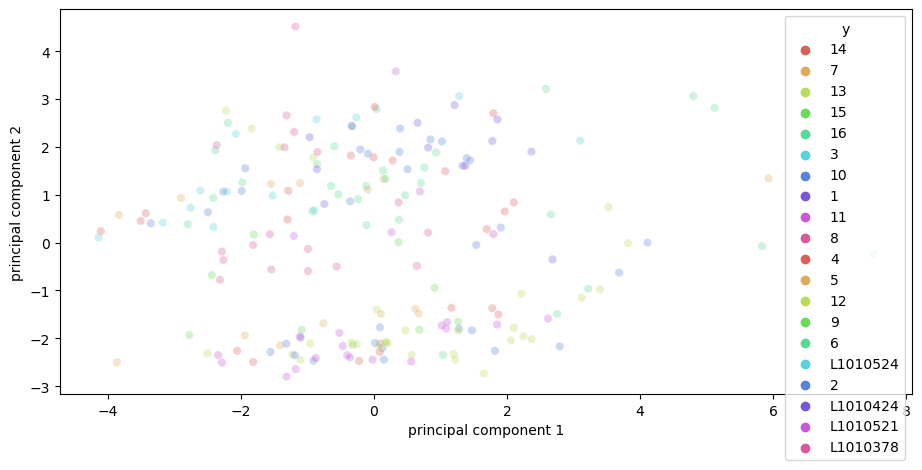

In [53]:
plt.figure(figsize=(11,5))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=principal_Df,
    legend="full",
    alpha=0.3
)

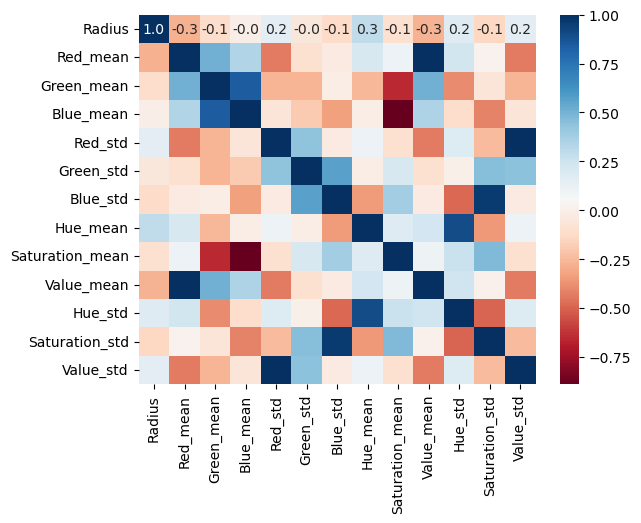

In [54]:
sns.heatmap(data_set.corr(), annot=True,
           cbar=True, cmap='RdBu', fmt='.1f')
plt.savefig('heatmap.png')
plt.show()

We don't want to see a too high correlation between the features (correlation greater than 0.8) in the dataset, as it can lead to data leakage or unnecessary increased complexity of the model. 

### Split the dataset in train & Validation

In [55]:
#split features_dataset with 70% for training and 30% for testing
labels = features_dataset['coin_label']
X = features_dataset.drop(columns=['Image_label'])
X = X.drop(columns=['coin_label'])
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.3, random_state=42)

In [56]:
X_train

,Radius,Red_mean,Green_mean,Blue_mean,Red_std,Green_std,Blue_std,Hue_mean,Saturation_mean,Value_mean,Hue_std,Saturation_std,Value_std
98,340.001373,192.534615,180.522221,166.004395,18.440503,23.679841,29.826136,0.101860,0.143952,0.755116,0.097800,0.093956,0.072323
31,234.502457,205.187308,177.643696,155.020526,13.393475,30.640025,49.342409,0.082910,0.244884,0.804660,0.058604,0.235413,0.052518
12,329.370850,185.997560,168.641872,137.018648,11.308468,23.988682,53.438479,0.103055,0.274201,0.729413,0.035092,0.262407,0.044338
35,245.436417,193.925420,177.030813,148.246557,19.024358,31.894858,60.235532,0.094648,0.256401,0.760502,0.041908,0.264146,0.074605
120,304.909729,191.966159,175.307191,145.016049,17.121441,28.947252,55.967598,0.097676,0.262608,0.752816,0.030251,0.245109,0.067146
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,269.141327,188.561506,177.923852,164.313086,20.061180,25.789918,35.423293,0.104046,0.138009,0.739612,0.113681,0.119567,0.078738
14,345.779541,174.476535,161.780367,142.047326,23.624045,30.119662,48.175832,0.110319,0.199805,0.684504,0.108555,0.218480,0.092808
92,292.446852,195.464483,171.409010,160.849041,17.648313,31.702367,32.556977,0.313914,0.204113,0.766768,0.366246,0.119952,0.069422
179,313.098206,179.153344,168.565934,154.376346,17.285298,23.824772,34.080791,0.098242,0.148625,0.702604,0.076281,0.117136,0.067819


In [57]:
#change the labels to numerical values
# change the y labels, now starting from 0 to 15 and not 1 to 16
y_train = y_train.astype('category').cat.codes
y_val = y_val.astype('category').cat.codes


In [58]:
# When patches were not labeled

# split the features_dataset in train and validation dataset with DataLoader
name_images = np.unique(features_dataset['Image_label'])

#70% training vs 30% validation
split_index = int(len(name_images) * 0.7)
train_array = name_images[:split_index]
validation_array = name_images[split_index:]

train_dataset = features_dataset[features_dataset['Image_label'].isin(train_array)]
#select the label in the training set, ! not the same order !
labels_train = labels[labels["id"].isin(train_array)]
# need to make the same size, repeat the labels by the number of rows for a given image 'Image_label'
# look how many times the image is repeated
repeated = train_dataset['Image_label'].value_counts()
# repeat the labels
labels_train = labels_train.loc[labels_train.index.repeat(repeated.values)]


validation_dataset = features_dataset[features_dataset['Image_label'].isin(validation_array)]
labels_validation = labels[labels["id"].isin(validation_array)]


print(len(train_dataset))
print(len(validation_dataset))
print(len(features_dataset))
print(len(labels_train))
print(train_dataset['Image_label'].unique())
print(labels_train['id'].unique())
print(labels_train)


KeyError: 'id'

#### How to combine the rows for one image to match the labels ?

do a prediction for each coin [0.85 0 0 0 0 ...]  (softmax) --> sum the prediction of each coin (soft max devrait mettre vers 1 dans une catégorie quand sûr) et compare avec le true label (loss MAE ou MSE à voir comment on sum qd bcp de pièce de 1 type, peut etre diviser par qqch)

### For model with our extracted features

#### when patches were not labeled

In [ ]:
class Coins_IMG(Dataset):
    """Coins dataset using 15 classes"""

    def __init__(self, dataframe_train, dataframe_label) -> None:
        """
        Attributes:
            raw_data (dataframe): (M) List of M slides raw data as dictionaries. 
            train (bool): True if data are the training set. False otherwise
            
        Args:
            features_path (str): The path to the features file
            train (bool): Whether it is the training dataset or not
        """
        
        super().__init__()
        # Load raw data from path
        self.raw_data = dataframe_train
        self.label_set = dataframe_label
        # Set if training or not
        #self.train = train

    def __len__(self) -> int:
        """Returns the length of the dataset (images)

        Returns:
            int: The length M of the dataset (nb of images)
        """

        n_data = 0 
        n_data = len(np.unique(self.raw_data['Image_label']))
        
        return n_data
    
    def __getitem__(self, index : int):
        """Returns the entry at index from the dataset

        Args:
            index (int): the requested entry index of the dataset (image index)

        Returns:
            features (torch.Tensor): (N, d) Feature tensor of the selected slide with N patches and d feature dimensions
            label (int): Ground truth label {0, ..., n_classes} of a image
            wsi_id (str): Name of the WSI as "DHMC_xxx" where xxx is a unique id of the slide (train == False only)
            coordinates (torch.Tensor): (N, 2) xy coordinates of the N patches of the selected slide (train == False only)
        """

        features = None
        label = None
        #wsi_id = None
        #coordinates = None
    
        set = np.unique(features_dataset['Image_label'])[index]
        #extract the features of the image with the label set
        raw_data = features_dataset[features_dataset['Image_label']==set]
        #extract features from this image
        features_t = raw_data.drop(columns=['Image_label'])
        features= features_t.astype(float)
        features = torch.tensor(np.array(features))
        label_raw = self.label_set[self.label_set["id"].isin(raw_data["Image_label"])]
        label_wth_id = label_raw.drop(columns=['id'])
        label = torch.tensor(np.array(label_wth_id))
        

        # check to prevent copies
        # if not self.train:
        #     #wsi_id = raw_data["wsi_id"]
        #     #coordinates = raw_data["patch_coordinates"]
        # # ------------------
        
        # if self.train:
        #     return features, label
        # else:
        #     return features, label
        return features, label

### When patches are labeled

In [75]:
class Coins_IMG_labeled(Dataset):
    """Coins dataset using 15 classes"""

    def __init__(self, dataframe_train, dataframe_label) -> None:
        """
        Attributes:
            raw_data (dataframe): (M) List of M slides raw data as dictionaries. 
            train (bool): True if data are the training set. False otherwise
            
        Args:
            features_path (str): The path to the features file
            train (bool): Whether it is the training dataset or not
        """
        
        super().__init__()
        # Load raw data from path
        self.raw_data = dataframe_train
        self.label_set = dataframe_label
        # Set if training or not
        #self.train = train

    def __len__(self) -> int:
        """Returns the length of the dataset (images)

        Returns:
            int: The length M of the dataset (nb of images)
        """

        n_data = 0 
        n_data = len(self.raw_data)
        
        return n_data
    
    def __getitem__(self, index : int):
        """Returns the entry at index from the dataset

        Args:
            index (int): the requested entry index of the dataset (image index)

        Returns:
            features (torch.Tensor): (N, d) Feature tensor of the selected slide with N patches and d feature dimensions
            label (int): Ground truth label {0, ..., n_classes} of a image
            wsi_id (str): Name of the WSI as "DHMC_xxx" where xxx is a unique id of the slide (train == False only)
            coordinates (torch.Tensor): (N, 2) xy coordinates of the N patches of the selected slide (train == False only)
        """

        features = None
        label = None
        #wsi_id = None
        #coordinates = None
    
        features_t = self.raw_data.iloc[index]
        features= features_t.astype(float)
        features = torch.tensor(np.array(features))

        label_t = self.label_set.iloc[index]
        label = float(label_t)
        label = torch.tensor(np.array(label_t))
        

        return features, label

In [76]:
X_train_dataset = Coins_IMG_labeled(X_train, y_train)
X_val_dataset = Coins_IMG_labeled(X_val, y_val)

In [ ]:
# When patches not labeled
train_dataset = Coins_IMG(train_dataset,labels_train)
val_dataset = Coins_IMG(validation_dataset,labels_validation)

In [24]:
import platform
# Get os name
os_name = platform.system().lower()
num_workers = 8
# OS X
if 'darwin' in os_name:
    print("Detected OS X")
    #%pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.1
# Linux 
elif 'linux' in os_name:
    print("Detected Linux")
    #%pip install torch==1.8.1+cpu torchvision==0.9.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
# Windows 
else:
    print("Detected Windows")
    num_workers = 0  # Hard fix for Windows users

Detected Windows


In [ ]:
# When patches not labeled
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=num_workers)

In [77]:
train_loader = DataLoader(X_train_dataset, batch_size=1, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(X_val_dataset, batch_size=1, shuffle=False, num_workers=num_workers)

### Linear Classifier

In [149]:
from utils import multiclass_cross_entropy_loss, cross_entropy_pooling, calculate_ranking_score
from sklearn.metrics import f1_score as f1

In [84]:
class AveragePooling(nn.Module):

    def __init__(self) -> None:
        super().__init__()

    def forward(self, features : torch.Tensor):
        
        if features.dim() == 1:
            return features

        mean = None
        
        mean = torch.mean(features, dim=0, keepdim=True)
        
        return mean

In [85]:
class LinearClassifier(nn.Module):

    def __init__(self, in_dim : int, H : int, n_classes : int, pooling_fn : nn.Module) -> None:

        super().__init__()

        proj_layer = None
        pool_layer = None
        fc_layer = None
        

        proj_layer = nn.Linear(in_dim, H)
        pool_layer = pooling_fn
        fc_layer = nn.Linear(H, n_classes)


        self.proj = proj_layer
        self.pool = pool_layer
        self.fc = fc_layer
        

    def forward(self, x):

        y = None

        x = np.squeeze(x)
        x = self.proj(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x= self.fc(x)
        y=nn.functional.relu(x)

        return y
     

In [86]:
@torch.no_grad()
def test(model : nn.Module, test_loader : DataLoader):

    model.eval()

    preds_dict = {"preds" : torch.Tensor(), "labels" : torch.Tensor(), 'losses': torch.Tensor()}
    for features, labels in test_loader:
        
        print("labels", labels)
        features = features.float()

        # Forward 
        preds = model(features)
        
        #compute loss
        loss = cross_entropy_pooling(labels, preds)
        

        # Store values
        preds_dict["preds"] = torch.cat([preds_dict["preds"], preds])
        preds_dict["labels"] = torch.cat([preds_dict["labels"], labels])
        preds_dict["losses"] = torch.cat([preds_dict["losses"], loss[None]])

    # Compute metric and loss
    ranking =calculate_ranking_score(preds_dict["labels"],preds_dict["preds"]) 
    loss = preds_dict["losses"].mean()

    return ranking, loss

In [87]:
def train(model : nn.Module, train_loader : DataLoader, val_loader : DataLoader, n_epochs : int, optimizer : torch.optim.Optimizer):

    # Initialize variable to return
    best_model = model.state_dict()
    best_epoch = 0
    best_f1 = 0
    train_losses = []
    val_losses = []
    val_f1s = []


    for epoch in range(n_epochs):
        model.train()
        loss_t = 0
        for features, labels in train_loader:
            # Dont keep track of the gradients
            optimizer.zero_grad()
            label=labels[0,0,:]
            features = features.float()

            # Forward 
            preds = model(features)
        
            #compute loss
            loss = cross_entropy_pooling(label, preds)
            
            loss.backward()
            optimizer.step()
            # take the mean to get corresponding shape with the validation loss
            loss_t = loss_t + loss.item()
              
        train_losses.append(loss_t/len(train_loader))
        ranking, val_loss = test(model, val_loader)
        val_f1s.append(ranking)
        val_losses.append(val_loss)
        if f1 > best_f1:
            best_f1 = f1
            # range() starts at 0 to epoch-1
            best_epoch = epoch+1
            # Need to return the best model
            best_model = copy.deepcopy(model.state_dict())

    
    return best_model, best_f1, best_epoch, val_f1s, val_losses, train_losses

In [150]:
# Set seed for reproducibility
torch.manual_seed(0)

# Display loss progression and f1 score
epochs = 30
d, H, n_classes = 13, 7, 16

# Create Linear classifier and optimizer
model = LinearClassifier(in_dim=d, H=H, n_classes=n_classes, pooling_fn=AveragePooling())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Run training and display results
_, best_f1, best_epoch, val_accs, val_loss, train_loss = train(model, train_loader, val_loader, n_epochs=epochs, optimizer=optimizer)
print(f"Best model at epoch {best_epoch} -> {100*best_f1:.2f}% F1 score")

IndexError: too many indices for tensor of dimension 1

In [ ]:
def plot_training(best_epoch: int, val_accs: list, val_loss: list, train_loss: list):
    """Plot training results of linear classifier
    
    Args:
        best_epoch (int): Best epoch
        val_accs (List): (E,) list of validation measures for each epoch
        val_loss (List): (E,) List of validation losses for each epoch
        train_loss (List): (E,) List of training losses for each epoch
    """

    # Create plot
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    es = np.arange(1, len(val_accs)+1)
    # Plot F1 score
    axes[0].plot(es, val_accs, label="Val")
    axes[0].vlines(best_epoch, ymin=np.min(val_accs), ymax=np.max(val_accs), color='k', ls='--', label="Best epoch")
    axes[0].set_xlabel("Training steps")
    axes[0].set_ylabel("F1-score")
    axes[0].set_title("F1-score")
    axes[0].legend()

    # Plot losses
    axes[1].plot(es, val_loss, label="Val")
    axes[1].plot(es, train_loss, label="Train")
    axes[1].vlines(best_epoch, ymin=np.min(train_loss), ymax=np.max(val_loss), color='k', ls='--', label="Best epoch")
    axes[1].set_xlabel("Training steps")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Losses")
    axes[1].legend()
    
    plt.tight_layout()

# Plot results
plot_training(best_epoch=best_epoch, val_accs=val_accs, val_loss=val_loss, train_loss=train_loss)

### Gradient Boosting Classifier

In [32]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, log_loss,classification_report
from utils import submission

In [33]:
#copy of what is above otherwise I forget
labels = features_dataset['coin_label']
X = features_dataset.drop(columns=['Image_label'])
X = X.drop(columns=['coin_label'])
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42)
# y_train = y_train.astype('int')
# y_val = y_val.astype('int')
y_val = y_val.astype('category').cat.codes
y_train = y_train.astype('category').cat.codes
# y_train = y_train.astype('category')
# y_val = y_val.astype('category')

In [34]:
# Potential parameters to look for tuning
params = {
    'objective': 'multiclass',
    'num_class': 16,
    'num_leaves': 15,                # Reduced number of leaves
    'min_data_in_leaf': 2,           # Increased minimum data in leaf
    'min_sum_hessian_in_leaf': 1e-3, # Small value to allow splits
    'lambda_l1': 0.6,                # L1 regularization
    'lambda_l2': 0.6,                # L2 regularization
    'learning_rate': 0.1,           # Lower learning rate
    'metric': ['multi_logloss'],        # Metric for multiclass classification
    'is_unbalance' : True,
    'verbose': -3
}
 
#params = {'num_leaves': 30,
#          'min_data_in_leaf': 20,
#          'objective': 'regression',
#          'max_depth': 3,
#          'learning_rate': 0.01,
#          "boosting": "gbdt",
#          "bagging_seed": 11,
#          "metric": 'rmse',
#          "lambda_l1": 0.2,
#          "verbosity": -1}


In [35]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    return [('f1', f1_score(y_true, np.argmax(y_hat,axis=1),average='macro'), True), ('accuracy', accuracy_score(y_true, np.argmax(y_hat,axis=1)),True)]

### How to get the f1 score and accuracy on the full training?

In [36]:
dtrain = lgb.Dataset(X_train, label=y_train)
valid_sets = lgb.Dataset(X_val, label=y_val)

# Cross-validation to determine the best number of boosting rounds
cv_results = lgb.cv(
    params,
    dtrain,
    num_boost_round=400,
    nfold=3,
    stratified=True,
    shuffle=True,
    metrics=['multi_logloss'],
    seed=42
)         
    
best_num_boost_round = len(cv_results['valid multi_logloss-mean'])
dic_pred = {}

# Train the model on the entire training data with the best number of boosting rounds
bst = lgb.train(params, dtrain, num_boost_round=best_num_boost_round, valid_sets=[dtrain,valid_sets], feval=lgb_f1_score, callbacks=[lgb.early_stopping(stopping_rounds=5),
                                                                                                                 lgb.record_evaluation(dic_pred)])
   
# Training loss (using the entire training set)
y_train_pred = bst.predict(X_train)
y_val_pred = bst.predict(X_val)

y_train_pred = np.argmax(y_train_pred, axis=1)
y_val_pred = np.argmax(y_val_pred, axis=1)

print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_val, y_val_pred)))
    

c:\Users\emy8\anaconda3\envs\iapr\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[7]	training's multi_logloss: 0.96342	training's f1: 0.873866	training's accuracy: 0.94382	valid_1's multi_logloss: 1.76528	valid_1's f1: 0.549373	valid_1's accuracy: 0.644444
LightGBM Model accuracy score: 0.6444


In [37]:
# Not the best way to estimate as might have unbalanced classes
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_train_pred)))
print('Training-set F1 score: {0:0.4f}'. format(f1_score(y_train, y_train_pred, average='macro')))
print('Validation-set accuracy score: {0:0.4f}'. format(accuracy_score(y_val, y_val_pred)))
print('Validation-set F1 score: {0:0.4f}'. format(f1_score(y_val, y_val_pred, average='macro')))

Training-set accuracy score: 0.9438
Training-set F1 score: 0.8739
Validation-set accuracy score: 0.6444
Validation-set F1 score: 0.5494


In [38]:
target_names = ['class 5CHF', 'class 2CHF', 'class 1CHF', 'class 0.5CHF', 'class 0.2CHF', 'class 0.1CHF', 'class 0.05CHF', 'class 2eu', 'class 1eu', 'class 0.5eu', 'class 0.2eu', 'class 0.1eu', 'class 0.05eu', 'class 0.02eu', 'class 0.01eu', 'class OoD']
print(classification_report(y_val, y_val_pred, target_names=target_names))
# support is the number of coins in one category

               precision    recall  f1-score   support

   class 5CHF       1.00      1.00      1.00         3
   class 2CHF       0.60      1.00      0.75         3
   class 1CHF       0.50      0.50      0.50         2
 class 0.5CHF       1.00      0.25      0.40         4
 class 0.2CHF       0.57      1.00      0.73         4
 class 0.1CHF       1.00      0.33      0.50         3
class 0.05CHF       1.00      1.00      1.00         1
    class 2eu       0.50      1.00      0.67         5
    class 1eu       1.00      0.80      0.89         5
  class 0.5eu       1.00      0.33      0.50         3
  class 0.2eu       0.00      0.00      0.00         2
  class 0.1eu       0.00      0.00      0.00         2
 class 0.05eu       0.00      0.00      0.00         2
 class 0.02eu       1.00      1.00      1.00         2
 class 0.01eu       0.75      1.00      0.86         3
    class OoD       0.00      0.00      0.00         1

     accuracy                           0.64        45
    macr

c:\Users\emy8\anaconda3\envs\iapr\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emy8\anaconda3\envs\iapr\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emy8\anaconda3\envs\iapr\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: y_true and y_pred contain different number of classes 16, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

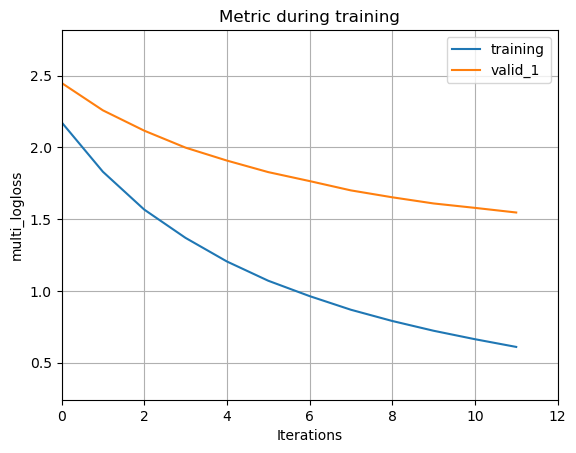

In [41]:
# change the name 'valid_0' to 'validation' for the plot
#dic_pred['validation'] = dic_pred.pop('valid_1')

lgb.plot_metric(dic_pred, metric='multi_logloss')
# Compute the log loss, similar to the cross-entropy loss
logloss = log_loss(y_val, y_val_pred)
logloss_t = log_loss(y_train, y_train_pred)
print('Achieved Validation Log loss:', logloss)
print('Achieved Training Log loss:', logloss_t)

Achieved Validation F1 score: 0.5493731962481962
Achieved Training F1 score: 0.8738656501007999


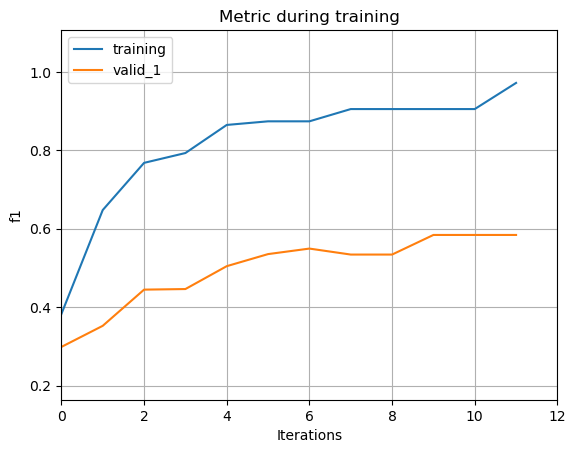

In [40]:
lgb.plot_metric(dic_pred, metric='f1')
# Compute the log loss, similar to the cross-entropy loss
logloss = f1_score(y_val, y_val_pred, average='macro')
logloss_t = f1_score(y_train, y_train_pred, average='macro')
print('Achieved Validation F1 score:', logloss)
print('Achieved Training F1 score:', logloss_t)

Achieved Validation Accuracy: 0.6444444444444445
Achieved Training Accuracy: 0.9438202247191011


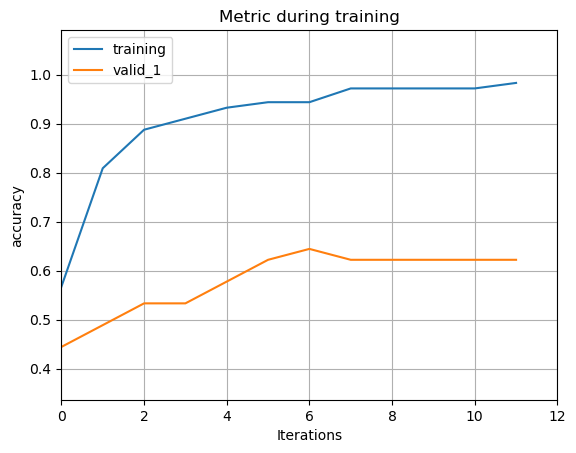

In [60]:
lgb.plot_metric(dic_pred, metric='accuracy')
# Compute the log loss, similar to the cross-entropy loss
logloss = accuracy_score(y_val, y_val_pred)
logloss_t = accuracy_score(y_train, y_train_pred)
print('Achieved Validation Accuracy:', logloss)
print('Achieved Training Accuracy:', logloss_t)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

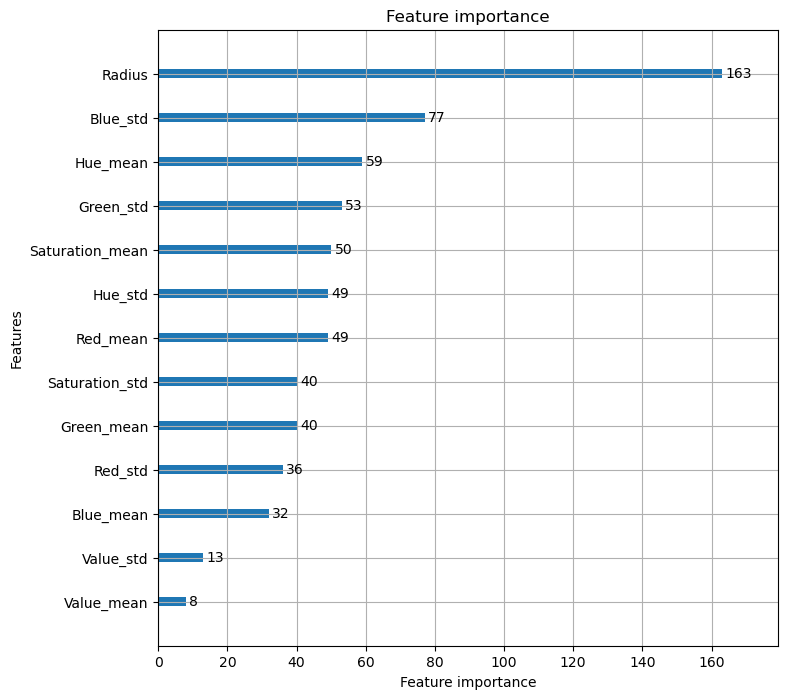

In [61]:
lgb.plot_importance(bst,figsize=(8,8))

In [121]:
id = ['id','5CHF','2CHF','1CHF','0.5CHF','0.2CHF','0.1CHF','0.05CHF','2EUR','1EUR','0.5EUR','0.2EUR','0.1EUR','0.05EUR','0.02EUR','0.01EUR','OOD']

# Create a submission dataframe full of zeros with the correct id
submission = pd.DataFrame(columns=id)
submission['id'] = np.unique(features_dataset['Image_label'])
submission = submission.fillna(0)
key = '5CHF'
submission.loc[submission['id']=='L1010277',key] += 1
print(submission)

#print(submission)

          id  5CHF  2CHF  1CHF  0.5CHF  0.2CHF  0.1CHF  0.05CHF  2EUR  1EUR  \
0   L1010277     2     0     0       0       0       0        0     0     0   
1   L1010279     0     0     0       0       0       0        0     0     0   
2   L1010281     0     0     0       0       0       0        0     0     0   
3   L1010283     0     0     0       0       0       0        0     0     0   
4   L1010287     0     0     0       0       0       0        0     0     0   
..       ...   ...   ...   ...     ...     ...     ...      ...   ...   ...   
58  L1010510     0     0     0       0       0       0        0     0     0   
59  L1010515     0     0     0       0       0       0        0     0     0   
60  L1010517     0     0     0       0       0       0        0     0     0   
61  L1010521     0     0     0       0       0       0        0     0     0   
62  L1010523     0     0     0       0       0       0        0     0     0   

    0.5EUR  0.2EUR  0.1EUR  0.05EUR  0.02EUR  0.01E

C:\Users\emy8\AppData\Local\Temp\ipykernel_160\736390458.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  submission = submission.fillna(0)


In [118]:
#add the image name to X_val
X_val_t = X_val.copy()
X_val_t['Image_label'] = features_dataset['Image_label'].iloc[X_val.index]


In [132]:
submission(X_val_t, y_val_pred,current_path)

          id  5CHF  2CHF  1CHF  0.5CHF  0.2CHF  0.1CHF  0.05CHF  2EUR  1EUR  \
0   L1010281     1     0     0       0       1       0        0     0     0   
1   L1010283     0     0     0       0       0       0        0     1     0   
2   L1010287     0     0     0       0       0       0        0     0     1   
3   L1010288     0     0     0       0       0       0        0     2     0   
4   L1010297     0     0     1       0       0       0        0     0     0   
5   L1010298     0     0     0       0       0       0        1     1     0   
6   L1010300     0     1     0       0       0       0        0     0     0   
7   L1010308     1     0     0       0       0       0        0     0     0   
8   L1010310     0     1     0       0       0       0        0     0     0   
9   L1010311     0     1     0       0       0       0        0     0     0   
10  L1010318     0     0     1       0       1       0        0     0     0   
11  L1010321     0     0     0       0       0      

C:\Users\emy8\AppData\Local\Temp\ipykernel_160\455966823.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  submission = submission.fillna(0)


### Pre-trained Model 

#### Fine_tuned resnet

### Without additional labels

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# Set seed for reproducibility
torch.manual_seed(0)

# Load the imageNet pre-trained model on ILSVRC2012 (aka ImageNet-1K) of maximum 400MB
#model = models.resnet18(pretrained=True).to(device)
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

num_ftrs = model.fc.in_features
num_classes = 16  # Number of coin types + 1 for out of distributions
model.fc = nn.Linear(num_ftrs, num_classes).to(device)


In [4]:
from utils import ImagePatchDataset,train_without_label
from utils import collate_fn, multiclass_cross_entropy_loss,calculate_ranking_score


In [5]:
base= "data-coin-counter/train"
root_dir = os.path.join(base, 'Patches')
root_true_label=os.path.join(base, 'train_labels.csv')

# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


dataset = ImagePatchDataset(root_dir,root_true_label, transform=transform)

# Check if dataset is loading correctly
print(f"Total groups: {len(dataset)}")


Total groups: 64


In [6]:
# Split the dataset
train_dataset, val_dataset = dataset.train_val_split(val_ratio=0.2)
# Create DataLoaders for each dataset
batch_size = 1
train_ = DataLoader(train_dataset, batch_size=batch_size,collate_fn=collate_fn, shuffle=True)
val_= DataLoader(val_dataset, batch_size=batch_size,collate_fn=collate_fn, shuffle=False)

for patches, labels, original_image in val_:
    # patches is a tensor containing all patches for the current original image
    # original_images is a list of original image identifiers (should be batch size 1 in this case)
    print(original_image)
    print("shapes of all the patches",patches.shape)
    print(labels)
    print(pd.read_csv(root_true_label, index_col=0).loc[original_image])
    break


('L1010377',)
shapes of all the patches torch.Size([4, 3, 224, 224])
(tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.]),)
5CHF       0
2CHF       0
1CHF       0
0.5CHF     1
0.2CHF     0
0.1CHF     0
0.05CHF    0
2EUR       1
1EUR       0
0.5EUR     0
0.2EUR     0
0.1EUR     0
0.05EUR    1
0.02EUR    1
0.01EUR    0
OOD        0
Name: L1010377, dtype: int64


In [ ]:
train_without_label(model, train_, val_)

### With Patches Labels

In [2]:
from utils import train_with_label, LabelledImagePatchDataset

In [3]:
# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

base= "data-coin-counter/train"
root_patches_with_labels = os.path.join(base, 'Patches')

dataset_labelled = LabelledImagePatchDataset(root_dir=root_patches_with_labels, transform=transform)

train_data, val_data = dataset_labelled.train_val_split(val_ratio=0.2)
batch_size = 16
train_labelled = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_labelled= DataLoader(val_data, batch_size=batch_size, shuffle=False)



In [ ]:
# Train the model
dataloaders = {'train': train_labelled, 'val': val_labelled}
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_with_label(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=1)



Epoch 0/0
----------


In [ ]:
# Save the best model
torch.save(model.state_dict(), 'best_model.pth')


# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))

